In [2]:
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from skimage.io import imread
from shutil import copyfile
print('Tensorflow version')
print(tf.__version__)
print(tf.config.list_logical_devices())
import matplotlib.pyplot as plt
plt.gray()
from sklearn.metrics import accuracy_score
import random
import json
import datetime


BATCH_SIZE = int(32.)
EPOCHS = int(512.)

batch_size = BATCH_SIZE
epochs = EPOCHS
learning_rate=0.001
CHANNELS=1
NLAYERS=2
SHRINK=1
NFILTERS=48
KSIZE=13
SUBSPACE=12
PATIENCE_ES=40
PATIENCE_RP=5


class NeymanScott:
    """
    Neyman-Scott point process using a Poisson variable for the number of parent points, uniform for
    the number of daughter points and Pareto distribution for the distance from the daughter points to
    the parent.
    """
    def __init__(self,
                 poisson_mean: float,
                 daughter_max: int,
                 pareto_alpha: float,
                 pareto_scale: float,
                 size: (int, int)):
        """
        :param poisson_mean: mean of the number of parent points
        :param daughter_max: maximum number of daughters per parent points
        :param pareto_alpha: alpha parameter of the Pareto distribution
        :param pareto_scale: scale used in the Pareto distribution. This parameter is
            applied before resizing the points from the [0, 1] interval to the size of the image.
        :param size: rescale the output to this size
        """
        self.poisson_mean = poisson_mean
        self.daughter_max = daughter_max
        self.pareto_alpha = pareto_alpha
        self.pareto_scale = pareto_scale
        self.size = np.array([size])
        self.generator = np.random.Generator(np.random.PCG64())

    def __call__(self):
        num_parents = self.generator.poisson(lam=self.poisson_mean)
        parents = self.generator.random((num_parents, 2))
        num_daughters = self.generator.integers(1, self.daughter_max, num_parents)
        points = np.empty((0, 2))

        for i in range(num_parents):
            # normalizes the pareto II distribution
            dist = self.generator.pareto(self.pareto_alpha, (num_daughters[i], 1))
            dist = (dist + 1) * self.pareto_scale
            angle = self.generator.uniform(0., 2 * np.pi, (num_daughters[i],))
            positions = np.stack([np.cos(angle), np.sin(angle)], 1)
            positions *= dist
            positions += parents[i, np.newaxis, :]
            points = np.concatenate([points, positions])
        # remove points outside the set [0, 1] x [0, 1]
        valid_points = np.logical_and(
            np.logical_and(0. <= points[:, 0], points[:, 0] <= 1.),
            np.logical_and(0. <= points[:, 1], points[:, 1] <= 1.)
        )
        points = points[valid_points, :]
        # scale to the image size
        points = points * self.size
        return points



NSAMPLES_TRAINING=2024*2
IMG_SIZE=128

poisson_mean=100
daughter_max=50
pareto_scale=.02
pareto_alpha=1. #GENERATION ON IT
gen = NeymanScott(poisson_mean, daughter_max, pareto_alpha, pareto_scale, (IMG_SIZE, IMG_SIZE))

generatedata=1
if generatedata==1:
    listIm=[]
    listY=[]
    for i in range(NSAMPLES_TRAINING):
        pareto_alpha=gen.generator.random(1)*10
        gen = NeymanScott(poisson_mean, daughter_max, pareto_alpha, pareto_scale, (IMG_SIZE, IMG_SIZE))
        points = gen()
        I=np.zeros([IMG_SIZE,IMG_SIZE])
        I[np.int64(np.floor(points[:, 0])), np.int64(np.floor(points[:, 1]))]=1
        listIm.append(I)
        listY.append(pareto_alpha)
    listIm=np.stack(listIm)
    listY=np.stack(listY)

    NSAMPLES_VALIDATION=512
    listImVal=[]
    listYVal=[]
    for i in range(NSAMPLES_VALIDATION):
        pareto_alpha=gen.generator.random(1)*10
        gen = NeymanScott(poisson_mean, daughter_max, pareto_alpha, pareto_scale, (IMG_SIZE, IMG_SIZE))
        points = gen()
        I=np.zeros([IMG_SIZE,IMG_SIZE])
        I[np.int64(np.floor(points[:, 0])), np.int64(np.floor(points[:, 1]))]=1
        listImVal.append(I)
        listYVal.append(pareto_alpha)

    listImVal=np.stack(listImVal)
    listYVal=np.stack(listYVal)
    np.save('listIm.npy',listIm)
    np.save('listImVal.npy',listImVal)
    np.save('listY.npy',listY)
    np.save('listYVal.npy',listYVal)
else:
    listIm=np.load('listIm.npy')
    listImVal=np.load('listImVal.npy')
    listY=np.load('listY.npy')
    listYVal=np.load('listYVal.npy')

print('listIm.shape',listIm.shape)
print('listImVal.shape',listImVal.shape)
print('listY.shape',listY.shape)
print('listYVal.shape',listYVal.shape)

listY=listY/9
listYVal=listYVal/9


Tensorflow version
2.13.0
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
listIm.shape (4048, 128, 128)
listImVal.shape (512, 128, 128)
listY.shape (4048, 1)
listYVal.shape (512, 1)


<Figure size 640x480 with 0 Axes>

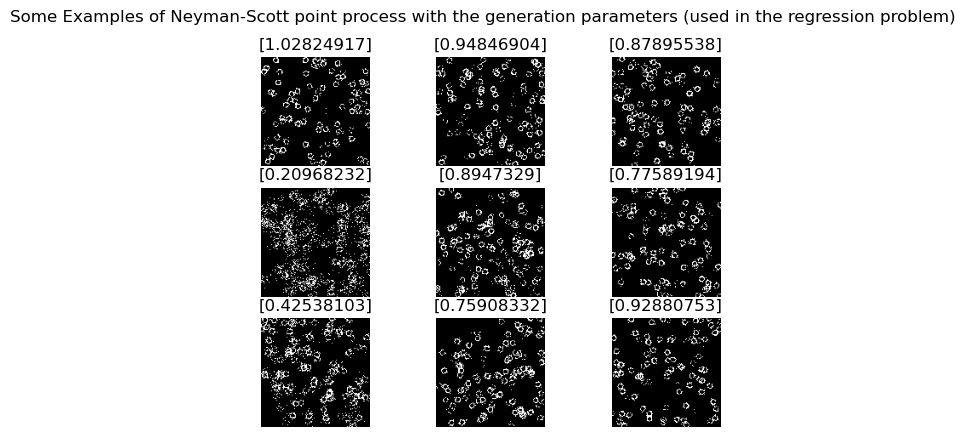

In [3]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(listIm[i])
    plt.title(str(listY[i]))
    plt.axis('off')
plt.suptitle('Some Examples of Neyman-Scott point process with the generation parameters (used in the regression problem)')
plt.show()

In [4]:
@tf.function
def dilation2d(x, st_element, strides, padding,rates=(1, 1)):
    """

    From MORPHOLAYERS

    Basic Dilation Operator
    :param st_element: Nonflat structuring element
    :strides: strides as classical convolutional layers
    :padding: padding as classical convolutional layers
    :rates: rates as classical convolutional layers
    """
    x = tf.nn.dilation2d(x, st_element, (1, ) + strides + (1, ),padding.upper(),"NHWC",(1,)+rates+(1,))
    return x

class DepthwiseDilation2D(Layer):
    '''
    Depthwise Dilation 2D Layer: Depthwise Dilation for now assuming channel last
    '''
    def __init__(self, kernel_size,depth_multiplier=1, strides=(1, 1),padding='same', dilation_rate=(1,1), kernel_initializer=tf.keras.initializers.RandomUniform(minval=-1., maxval=0.),
    kernel_constraint=None,kernel_regularization=None,**kwargs):
        super(DepthwiseDilation2D, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.depth_multiplier= depth_multiplier
        self.strides = strides
        self.padding = padding
        self.rates=dilation_rate
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.kernel_constraint = tf.keras.constraints.get(kernel_constraint)
        self.kernel_regularization = tf.keras.regularizers.get(kernel_regularization)
        # for we are assuming channel last
        self.channel_axis = -1

        # self.output_dim = output_dim

    def build(self, input_shape):
        if input_shape[self.channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')

        input_dim = input_shape[self.channel_axis]
        kernel_shape = self.kernel_size + (input_dim,self.depth_multiplier)
        self.kernel2D = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel2D',constraint =self.kernel_constraint,regularizer=self.kernel_regularization)
        super(DepthwiseDilation2D, self).build(input_shape)

    def call(self, x):
        res=[]
        for di in range(self.depth_multiplier):
            H=tf.nn.dilation2d(x,self.kernel2D[:,:,:,di],strides=(1, ) + self.strides + (1, ),padding=self.padding.upper(),data_format="NHWC",dilations=(1,)+self.rates+(1,))
            res.append(H)
        return tf.concat(res,axis=-1)

    def compute_output_shape(self, input_shape):

        space = input_shape[1:-1]
        new_space = []
        for i in range(len(space)):
            new_dim = conv_utils.conv_output_length(
                space[i],
                self.kernel_size[i],
                padding=self.padding,
                stride=self.strides[i],
                dilation=self.rates[i])
            new_space.append(new_dim)

        return (input_shape[0],) + tuple(new_space) + (self.depth_multiplier,)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_filters': self.num_filters,
            'kernel_size': self.kernel_size,
            'depth_multiplier': self.depth_multiplier,
            'strides': self.strides,
            'padding': self.padding,
            'dilation_rate': self.rates,
        })
        return config

## Example of results of Dilation operator
First row is the originan N-S point process.
Second row is the dilation by a square of 3x3

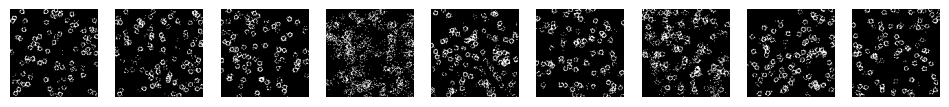

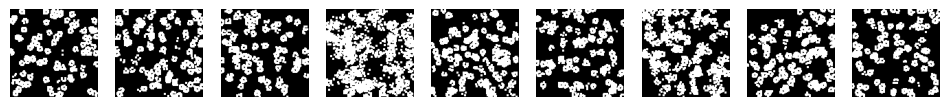

In [5]:
listImDil=dilation2d(tf.expand_dims(listIm[0:10],axis=-1), tf.zeros([3,3,1],dtype='float64'), (1,1), 'SAME')

plt.figure(figsize=(12,24))
for i in range(9):
     plt.subplot(1,9,i+1)
     plt.imshow(listIm[i])
     plt.axis('off')
plt.show()
plt.figure(figsize=(12,24))
for i in range(9):
     plt.subplot(1,9,i+1)
     plt.imshow(listImDil[i])
     plt.axis('off')

plt.show()

In [6]:
CaplistImDil=tf.reduce_mean(dilation2d(tf.expand_dims(listIm,axis=-1), tf.zeros([3,3,1],dtype='float64'), (1,1), 'SAME'),axis=(1,2,3))

Text(0, 0.5, 'Alpha in the Neymann Scott point process')

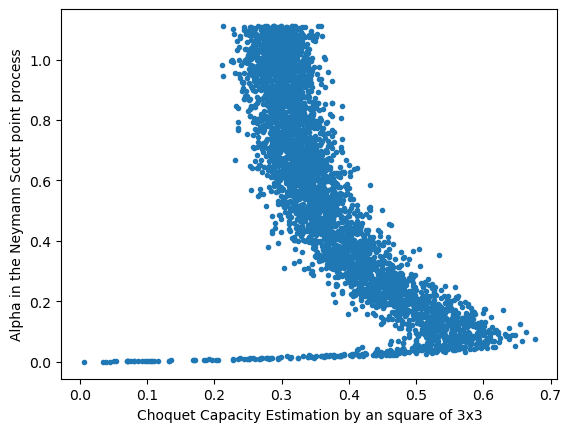

In [7]:
plt.plot(CaplistImDil,listY,'.')
plt.xlabel('Choquet Capacity Estimation by an square of 3x3')
plt.ylabel('Alpha in the Neymann Scott point process')

In [8]:
print('Proposed model')
xinput = layers.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
xconv=xinput
for i in range(NLAYERS):
    xconv = layers.Conv2D(NFILTERS,(3,3),padding='same',activation='relu')(xconv)
if NLAYERS>0:
    xconv = layers.Conv2D(NFILTERS//SHRINK,(1,1),padding='same',activation='relu')(xconv)
    xconv = DepthwiseDilation2D((KSIZE,KSIZE),depth_multiplier=SHRINK,padding='same')(xconv)
else:
    xconv = DepthwiseDilation2D((KSIZE,KSIZE),depth_multiplier=NFILTERS,padding='same')(xconv)
xfeatures=layers.GlobalAveragePooling2D()(xconv)
xfeatures=layers.BatchNormalization()(xfeatures)
xfeatures=layers.Dense(SUBSPACE,activation='relu')(xfeatures)
xfeatures=layers.Dense(SUBSPACE)(xfeatures)
xend=layers.Dense(1,activation='sigmoid')(xfeatures)
modelDil=tf.keras.Model(xinput,xend)
modelDil.summary()
print('Number of parameters: ' +str(modelDil.count_params()))
tf.keras.utils.plot_model(modelDil)

CB2=[tf.keras.callbacks.EarlyStopping(patience=PATIENCE_ES,restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=PATIENCE_RP,min_lr=1e-6),
#    tf.keras.callbacks.CSVLogger(dir_autosave_model_stat+'Dil', separator=',', append=False)
   ]
modelDil.compile(loss="mae", optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), metrics=["mse","mae"])

Proposed model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 48)      480       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 48)      20784     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 48)      2352      
                                                                 
 depthwise_dilation2d (Dept  (None, 128, 128, 48)      8112      
 hwiseDilation2D)                                                
                                                                 
 global_average_pooling2d (  (None, 48)                0         
 GlobalAveragePooling2D)                      

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 48)      480       
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 48)      20784     
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 48)      2352      
                                                                 
 depthwise_conv2d (Depthwis  (None, 128, 128, 48)      8112      
 eConv2D)                                                        
                                                                 
 global_average_pooling2d_1  (None, 48)                0         
  (GlobalAveragePooling2D)                                 

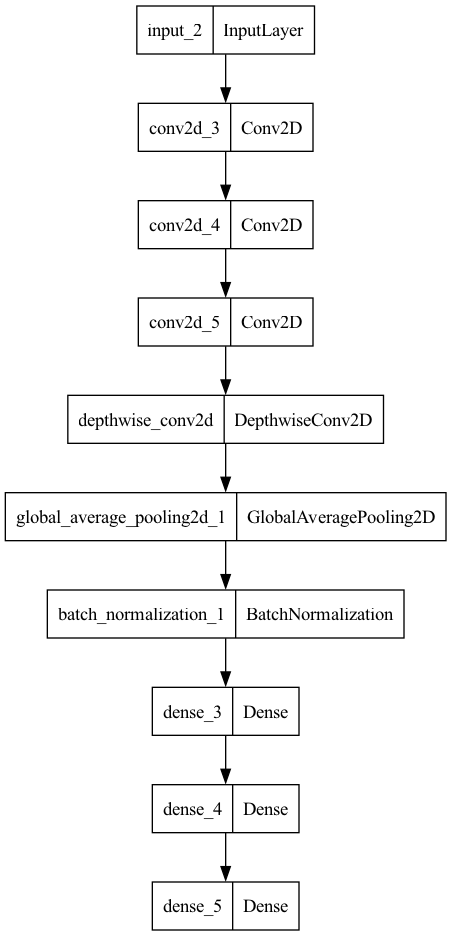

In [9]:
xinput = layers.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
xconv=xinput
for i in range(NLAYERS):
    xconv = layers.Conv2D(NFILTERS,(3,3),padding='same',activation='relu')(xconv)
if NLAYERS>0:
    xconv = layers.Conv2D(NFILTERS//SHRINK,(1,1),padding='same',activation='relu')(xconv)
    xconv = layers.DepthwiseConv2D((KSIZE,KSIZE),depth_multiplier=SHRINK,use_bias=False,padding='same')(xconv)
else:
    xconv = layers.DepthwiseConv2D((KSIZE,KSIZE),depth_multiplier=NFILTERS,use_bias=False,padding='same')(xconv)
xfeatures=layers.GlobalAveragePooling2D()(xconv)
xfeatures=layers.BatchNormalization()(xfeatures)
xfeatures=layers.Dense(SUBSPACE,'relu')(xfeatures)
xfeatures=layers.Dense(SUBSPACE)(xfeatures)
xend=layers.Dense(1,activation='sigmoid')(xfeatures)
modelDWConv=tf.keras.Model(xinput,xend)
modelDWConv.summary()
print('Number of parameters: ' +str(modelDWConv.count_params()))

CBDW=[tf.keras.callbacks.EarlyStopping(patience=PATIENCE_ES,restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=PATIENCE_RP,min_lr=1e-6),
#    tf.keras.callbacks.CSVLogger(dir_autosave_model_stat+'DWConv', separator=',', append=False)
   ]
modelDWConv.compile(loss="mae", optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), metrics=["mse","mae"])
tf.keras.utils.plot_model(modelDWConv)



Classical Convolutional model
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 48)      480       
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 48)      20784     
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 48)      389376    
                                                                 
 global_average_pooling2d_2  (None, 48)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_2 (Bat  (None, 48)                192       
 chNormalization)            

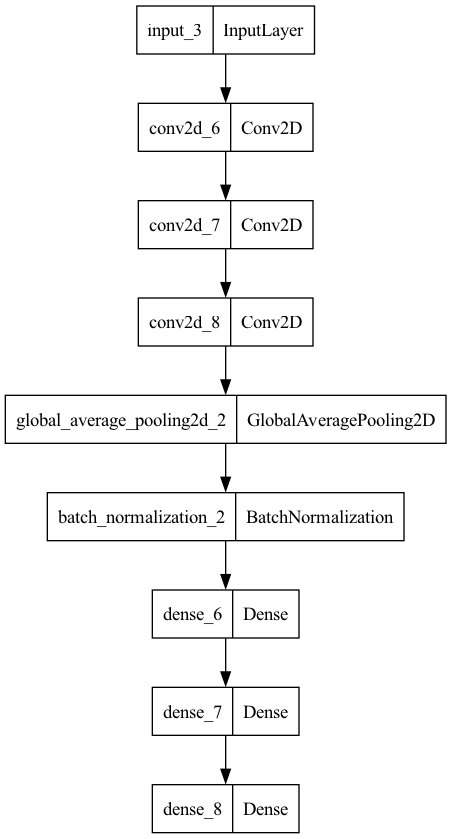

In [10]:
print('Classical Convolutional model')

xinput = layers.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
xconv=xinput
for i in range(NLAYERS):
    xconv = layers.Conv2D(NFILTERS,(3,3),padding='same',activation='relu')(xconv)
xconv=layers.Conv2D(NFILTERS,(KSIZE,KSIZE),use_bias=False,padding='same')(xconv)
xfeatures=layers.GlobalAveragePooling2D()(xconv)
xfeatures=layers.BatchNormalization()(xfeatures)
xfeatures=layers.Dense(SUBSPACE,'relu')(xfeatures)
xfeatures=layers.Dense(SUBSPACE)(xfeatures)
xend=layers.Dense(1,activation='sigmoid')(xfeatures)
modelConv=tf.keras.Model(xinput,xend)
modelConv.summary()
print('Number of parameters: ' +str(modelConv.count_params()))

CB1=[tf.keras.callbacks.EarlyStopping(patience=PATIENCE_ES,restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=PATIENCE_RP,min_lr=1e-6),
#    tf.keras.callbacks.CSVLogger(dir_autosave_model_stat+'Conv', separator=',', append=False)
   ]
modelConv.compile(loss="mae", optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), metrics=["mse","mae"])
tf.keras.utils.plot_model(modelConv)

In [ ]:
#Training the model
#You need at least a good GPU to run the experiments
histDil=modelDil.fit(listIm, listY, batch_size=batch_size, epochs=epochs,callbacks=CB2,validation_data=(listImVal, listYVal))
histDWConv=modelDWConv.fit(listIm, listY, batch_size=batch_size, epochs=epochs,callbacks=CBDW,validation_data=(listImVal, listYVal))
histConv=modelConv.fit(listIm, listY, batch_size=batch_size, epochs=epochs,callbacks=CB1,validation_data=(listImVal, listYVal))
